In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
import IPython.display

2023-04-14 13:42:09.934241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option("display.max_row", 200)

In [3]:
df = pd.read_csv("data/all_data_aggr_nonan.csv", index_col=0)

In [4]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
              'activity', 'screen', 'call', 'sms', 'appCat.builtin',
              'appCat.communication', 'appCat.entertainment', 'appCat.finance',
              'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
              'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days'  # always correct
IN_STEPS = 20  # use 7 days
OUT_STEPS = 1  # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

In [5]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

test_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)

test_window.update_datasets(train_series, val_series, test_series, norm=True)

2023-04-14 13:42:16.898563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='relu')
])

MAX_EPOCHS = 20

In [7]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [8]:
history = compile_and_fit(lstm_model, test_window)
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(test_window.val)
performance['LSTM'] = lstm_model.evaluate(test_window.test, verbose=0)

Epoch 1/20
61/61 [==============================] - 9s 65ms/step - loss: 1.6436 - mean_absolute_error: 1.0157 - val_loss: 3.2129 - val_mean_absolute_error: 1.6281
Epoch 2/20
61/61 [==============================] - 3s 36ms/step - loss: 1.6244 - mean_absolute_error: 0.9833 - val_loss: 3.2707 - val_mean_absolute_error: 1.6320
Epoch 3/20
27/27 [==============================] - 1s 7ms/step - loss: 3.2796 - mean_absolute_error: 1.6326


tf.Tensor(
[[0.41820353]
 [0.        ]
 [0.2670688 ]
 [0.        ]
 [0.55093783]
 [0.        ]
 [0.        ]
 [0.544809  ]], shape=(8, 1), dtype=float32)
tf.Tensor(
[[0.41820353]
 [0.        ]
 [0.2670688 ]
 [0.        ]
 [0.55093783]
 [0.        ]
 [0.        ]
 [0.544809  ]], shape=(8, 1), dtype=float32)
tf.Tensor(
[[0.41820353]
 [0.        ]
 [0.2670688 ]
 [0.        ]
 [0.55093783]
 [0.        ]
 [0.        ]
 [0.544809  ]], shape=(8, 1), dtype=float32)


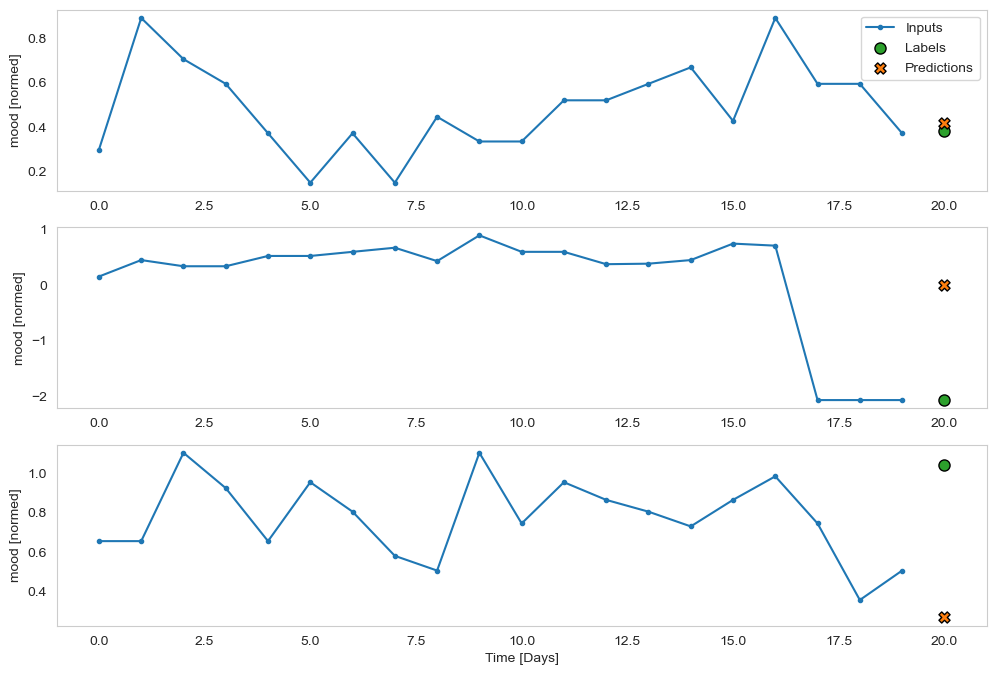

In [9]:
test_window.plot(lstm_model, single=True)